# Final Project:   Building a Basic MNIST MultiClass Classifier from Scratch

CUNY MSDA - DATA 602: Advanced Programming Techniques<br>
_Author - Walt Wells_

## Overview

The DATA 602 - Advanced Programming Techniques Final Project will serve as an opportunity to learn more about image manipulation and multiclass classification.   

I propose to build a simple multiclass classifier from scratch that finds a distance metric between a sample image and a dataset contrived from the mean pixel values of each class.  This is inspired by ideas proposed in section 4.2 of Tim Chartier's "When Life Is Linear" book.  Once we have our predictions, we will describe and interpret the performance of our multiclass classifier.  

MNIST seems to be a good choice since there are a lot of existing materials on using this dataset.   I don't expect to contribute anything new to MNIST research.  My focus will instead be on building from scratch each step required for multiclass classification.  While more effective models are likely available in existing python libraries like scikit-learn, tensorflow, and others, initially avoiding the 'blackbox' and building by hand will lead to a greater comprehension of the requirements for training, testing, and evaluating the performance of a multiclass classifier. 

## Data

"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. " - http://yann.lecun.com/exdb/mnist/

Data Curation: 
* Yann LeCun, Courant Institute, NYU
* Corinna Cortes, Google Labs, New York
* Christopher J.C. Burges, Microsoft Research, Redmond

## Resources

This Jupyter notebook is set up on a VM as part of an allocation grant from the [Open Science Data Cloud](https://www.opensciencedatacloud.org).  The OSDC offers services similar to commercial cloud providers like AWS, Azure and Google Compute, but is designed to serve the 'long tail' of the data science community by providing allocation grants to researchers in need of resources.  I help manage the operations of the OSDC as part of my work with the Open Commons Consortium (occ-data.org). 

The full MNIST dataset is not large, and can be managed from the ephemeral storage in the VM.  I port forward the jupyter notebook through a proxy server and work in a browser on my local machine. Github is used to manage the code. 

## Environment Prep

In [1]:
import os
import struct
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

## Data Import and Preparation

In [2]:
def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set as a pandas data frame. 
    The first column is the label/class, the other 784 columns are the pixel values.  
    Uses code liberally from https://gist.github.com/akesling/5358964, but works to build
    a table similar to the Kaggle digit recognizer dataset: https://www.kaggle.com/c/digit-recognizer
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"
    
    # get labels
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.uint8)

    # get pixel values
    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), 1, 784)
        img = img.tolist()
        img = list(itertools.chain(*img))
    
    data = [] #initialize list
    
    # get row for DF
    def get_img(idx): 
        row = img[idx]
        row.insert(0, lbl[idx])
        return row

    # populate list with rows for each image
    for i in xrange(len(lbl)):
        data.append(get_img(i))
    
    # convert to df
    df = pd.DataFrame(data)
    df.rename(columns={0:'label'}, inplace=True)
    return df

### Import Train and Testing Data

In [3]:
mtrain = read("training")
mtest = read("testing")
print "Training Data: ", mtrain.shape
print "Testing Data: ", mtest.shape

Training Data:  (60000, 785)
Testing Data:  (10000, 785)


The code below is for testing different splits of training and test.

In [4]:
#alld = pd.concat([mtrain, mtest])
#print alld.shape
#msk = np.random.rand(len(alld)) < 0.8
#mtrain = alld[msk]
#mtest = alld[~msk]
#print mtrain.shape
#print mtest.shape

### Review Training and Test Label Distributions

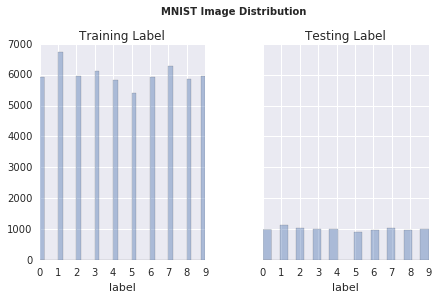

In [5]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plt.suptitle('MNIST Image Distribution', fontweight='bold')
sns.distplot(mtrain.label, kde=False, ax=ax1).set_title('Training Label');
sns.distplot(mtest.label, kde=False, ax=ax2).set_title('Testing Label');
plt.subplots_adjust(top=.85, bottom=0.1, left=0.05, right=0.95, hspace=0.8,
                    wspace=0.35)

## Image Visualization

In [6]:
def rowconverter(df, idx):
    """
    given a df and a index, get a label for the image, and convert 
    back to a 28^2 np.array
    """
    row = df.loc[[idx]]
    label = row.iloc[0]['label']
    row.pop('label')
    image = row.as_matrix().reshape(28,28)
    return label, image

# Both of the visualization tools below contain code taken liberally from
# https://gist.github.com/akesling/5358964

def ascii_show(image):
    """
    Show pixel values in formation
    """
    for y in image[1]:
         row = ""
         for x in y:
             row += '{0: <4}'.format(x)
         print row
        
def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    title = "Image Label : " + str(image[0])
    fig = plt.figure()
    plt.title(title)
    imgplot1 = plt.imshow(image[1], cmap=mpl.cm.Greys)
    imgplot1.set_interpolation('nearest')
    plt.show()

### Visualize Random Example in Training Data

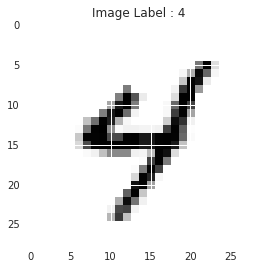

0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   154 253 56  0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   19  107 247 171 19  0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   85  252 238 38  0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   151 0   0   0   0   0   26  210 252 125 0   0   

In [7]:
img = rowconverter(mtrain, randint(0,len(mtrain)))

show(img)
ascii_show(img)

## Build a Simple Classifier

We will build a classifier that operates somewhat like a k-means clustering algorithm, but where we know in advance our k and the means of each of our clusters.   We will calculate each of the cluster means by taking the mean value of each pixel for handwritten label class in our training data.    

Then we will make our predictions by calculating the distance an image is from each "cluster".   

### Create Mean Pixel Data for Clustering

In [8]:
meanClass = mtrain.groupby(['label']).mean()
meanClass.reset_index(level=0, inplace=True)

### Visualize Mean Results

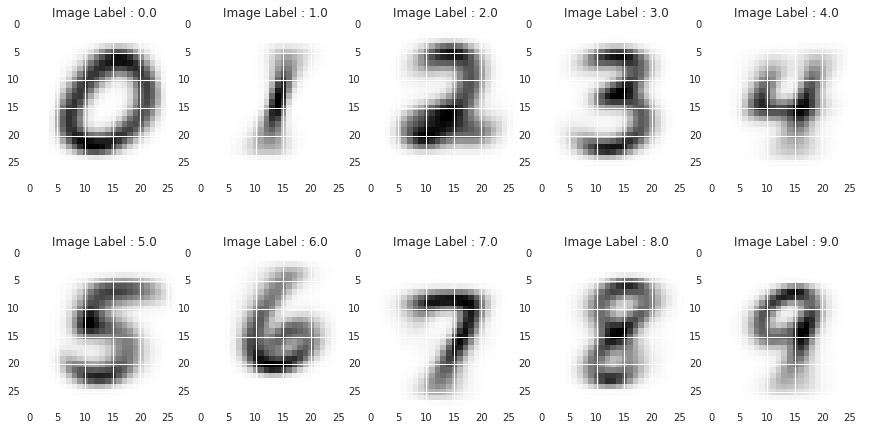

In [9]:
fig, axarr = plt.subplots(2,5, figsize=(15,8))
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axarr.ravel()

for i in range(len(meanClass)):
    img = rowconverter(meanClass, i)
    title = "Image Label : " + str(img[0])
    axs[i].set_title(title)
    imgplot = axs[i].imshow(img[1])
    imgplot.set_interpolation('nearest')

### Get Distances to our MeanClass

#### Euclidean Norm
* $m$ = our meanClass dataset
* $t$ = a single vector representing an image

$||m - t||_2$

Here we want the _lowest_ distance to determine the correct prediction. 

In [10]:
def eucDist(single):
    """
    given an image, calculate the Euclidean distance to the values
    in our meanClass dataset, and return a prediction and value
    """
    label = np.asscalar(single['label'])

    result = pd.DataFrame(meanClass.values - single.values, columns=meanClass.columns)
    result.drop(result.columns[[0]], axis=1, inplace=True)

    result = np.square(result)
    eucdist = np.sqrt(result.sum(axis=1))
    eucdist

    predict, dist = eucdist.idxmin(), eucdist.min()

    
    return [label, predict, dist]

#### Cosine Distance
$\frac{m \times t}{||m||_2 \times ||t||_2}$

Here we want the _greatest_ distance value (closest to 1) to determine the correct prediction. 

In [11]:
def cosDist(single):
    """
    given an image, calculate the Cosine distance to the values
    in our meanClass dataset, and return a prediction and value
    """
    m = meanClass.copy()  ## should be a cleaner way to do this?
    m.drop(m.columns[[0]], axis=1, inplace=True)

    label = np.asscalar(single['label'])

    t = pd.DataFrame(single)

    t.drop(['label'], inplace=True)
    tran_t = t.transpose()

    numerator = np.dot(m, t).T

    m_2 = np.sqrt(np.square(m).sum(axis=1))
    t_2 = np.sqrt(np.square(tran_t).sum(axis=1))
    
    denominator = m_2.values * t_2.values

    cosdist = np.divide(numerator, denominator)
    predict, dist = np.argmax(cosdist), cosdist.max()
    
    return [label, predict, dist]

### Test by predicting a single image

In [12]:
img = mtest[0:1]
euc_img = img.apply(eucDist, axis=1)
cos_img = img.apply(cosDist, axis=1)

print "Test Class: ", euc_img[0][0]
print "---------------------------------------"
print "Euclidean Distance"
print "Predicted Class: ", euc_img[0][1], " |  Distance of: ", euc_img[0][2]
print "Is this prediction correct: ", euc_img[0][1] == euc_img[0][1]
print "---------------------------------------"
print "Cosine Distance"
print "Predicted Class: ", cos_img[0][1], " |  Distance of: ", cos_img[0][2]
print "Is this prediction correct: ", cos_img[0][0] == cos_img[0][1]

Test Class:  7
---------------------------------------
Euclidean Distance
Predicted Class:  7  |  Distance of:  1221.30925287
Is this prediction correct:  True
---------------------------------------
Cosine Distance
Predicted Class:  7  |  Distance of:  0.783245174237
Is this prediction correct:  True


### Predict all test data

In [13]:
euc_results = mtest.apply(eucDist, axis=1)
cos_results = mtest.apply(cosDist, axis=1)

### Create a single DF

In [14]:
eucdf = pd.DataFrame(euc_results, columns=['tags'])
eucdf = eucdf['tags'].apply(pd.Series)
eucdf.columns = ['label', 'eucPred', 'eucDist']
eucdf['label'] = eucdf['label'].astype(int)
eucdf['eucPred'] = eucdf['eucPred'].astype(int)

cosdf = pd.DataFrame(cos_results, columns = ['tags'])
cosdf = cosdf['tags'].apply(pd.Series)
cosdf.columns = ['label', 'cosPred', 'cosDist']
cosdf['label'] = cosdf['label'].astype(int)
cosdf['cosPred'] = cosdf['cosPred'].astype(int)

finaldf = pd.concat([eucdf, cosdf], axis=1)
finaldf = finaldf.loc[:,~finaldf.columns.duplicated()]

finaldf['eucCorrect'] = finaldf['label']==finaldf['eucPred']
finaldf['cosCorrect'] = finaldf['label']==finaldf['cosPred']

finaldf.head(5)

,label,eucPred,eucDist,cosPred,cosDist,eucCorrect,cosCorrect
0,7,7,1221.309253,7,0.783245,True,True
1,2,2,2048.531505,2,0.592662,True,True
2,1,1,897.925426,1,0.792133,True,True
3,0,0,1568.431748,0,0.850993,True,True
4,4,4,1533.680576,4,0.657409,True,True


## Describe Model Performance

Since this is a multi-class classifier, we will start by describing the overall accuracy of our classifier.   This will essentially be a binary.   Either it predicted correctly or it did not. 

The we will delve deeper to determine which numbers our baby model predicted correctly, the precision, recall and F1 scores for each class, and review and plot confusion matrices to better understand our classifier behavior.

### Get Overall Error Rate

In [15]:
eucCorrect = np.sum(finaldf.eucCorrect)
eucErr = 1 - (eucCorrect / float(len(mtest)))

cosCorrect = np.sum(finaldf.cosCorrect)
cosErr = 1 - (cosCorrect / float(len(mtest)))

print "Euclidean Distance"
print "Error rate: ", eucErr, "| Correct: ", 1-eucErr
print "---------------------------------------"
print "Cosine Distance"
print "Error rate: ", cosErr, "| Correct: ", 1-cosErr

Euclidean Distance
Error rate:  0.1797 | Correct:  0.8203
---------------------------------------
Cosine Distance
Error rate:  0.1784 | Correct:  0.8216


### Accuracy by Number/Class

In [16]:
eucCross = pd.crosstab(finaldf["label"], finaldf["eucCorrect"], margins=True, normalize='index')
cosCross = pd.crosstab(finaldf["label"], finaldf["cosCorrect"], margins=True, normalize='index')

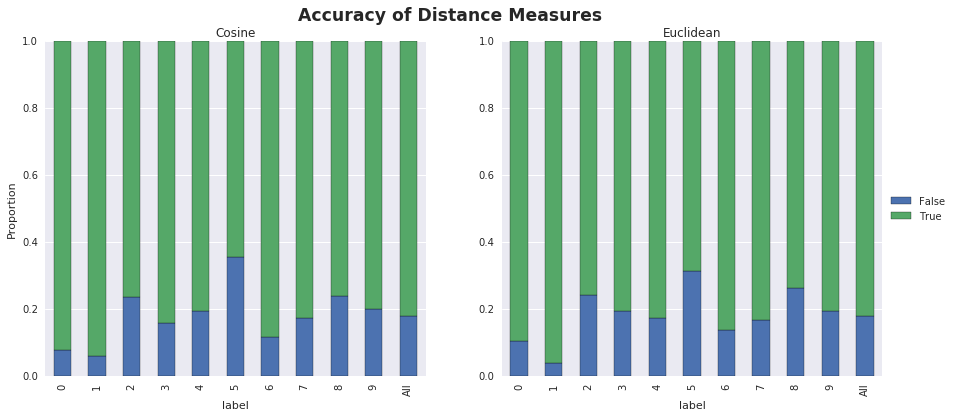

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))
cosCross.plot(kind="bar", stacked=True, ax=axs[0])
axs[0].set_title("Cosine")
eucCross.plot(kind="bar", stacked=True, ax=axs[1])
axs[1].set_title("Euclidean")
axs[0].set_ylabel("Proportion")
axs[0].legend_.remove()
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Accuracy of Distance Measures', fontsize='xx-large', fontweight='bold')
plt.show()

### Confusion Matrix

In [18]:
def plot_confusion_matrix(df_confusion, title):
    """
    plot a crosstab confusion matrix using matplotlib. 
    taken from example at: 
    http://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    """
    plt.figure(figsize=(8,8))
    plt.matshow(df_confusion, cmap='coolwarm', fignum=1)
    plt.title(title, fontweight='bold', y=1.08)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

eucPred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,878,0,7,2,2,58,25,1,7,0
1,0,1092,10,3,0,7,3,0,20,0
2,19,71,781,33,31,3,23,18,50,3
3,4,24,25,814,1,49,8,15,58,12
4,1,22,2,0,811,3,16,1,10,116
5,11,63,2,118,21,612,27,10,13,15
6,18,27,22,0,31,32,827,0,1,0
7,2,59,22,1,20,2,0,856,13,53
8,14,39,11,83,12,36,13,10,718,38


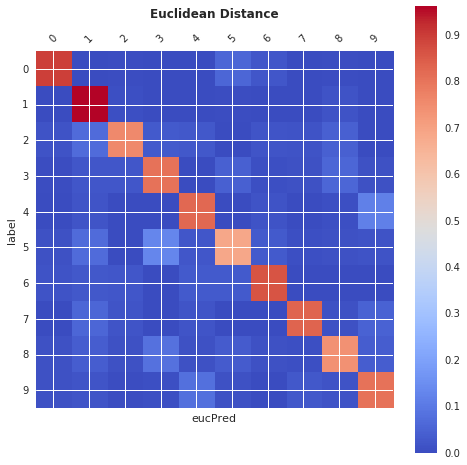

In [19]:
eucConf = pd.crosstab(finaldf['label'], finaldf['eucPred'])
eucConf_norm = pd.crosstab(finaldf['label'], finaldf['eucPred'], normalize='index')
plot_confusion_matrix(eucConf_norm, "Euclidean Distance")
eucConf

cosPred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,903,0,6,3,0,33,24,1,10,0
1,0,1065,8,5,0,4,4,0,49,0
2,27,35,789,45,25,0,32,15,59,5
3,6,4,26,851,1,30,8,13,53,18
4,6,10,3,0,792,1,23,1,20,126
5,30,25,13,135,19,574,26,10,38,22
6,30,13,20,1,17,24,845,0,8,0
7,8,48,25,0,17,0,1,849,24,56
8,8,18,12,91,10,30,17,10,742,36


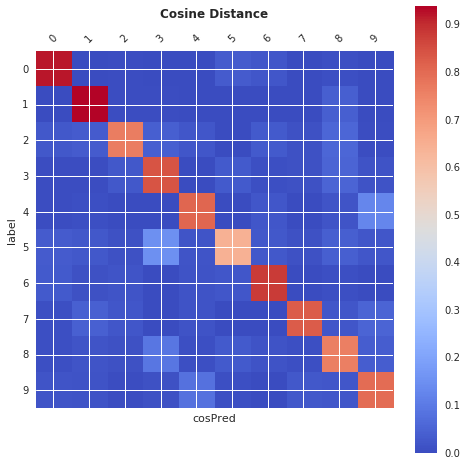

In [20]:
cosConf = pd.crosstab(finaldf['label'], finaldf['cosPred'])
cosConf_norm = pd.crosstab(finaldf['label'], finaldf['cosPred'], normalize='index')
plot_confusion_matrix(cosConf_norm, "Cosine Distance")
cosConf

In [21]:
def getmetrics(df, i):
    """
    given a confusion matrix, return multiple metrics for a given label
    tp = true positive, fp = false positive, fn = false negative
    precision recall and f1 scores
    """
    tp = df.iat[i,i]
    fp = df[i].sum() - tp
    fn = df.iloc[i,:].sum() - tp
    precision = float(tp) / (tp + fp)
    recall = float(tp) / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return [tp, fp, fn, precision, recall, f1]

x = []
for index, row in eucConf.iterrows():
    x.append(getmetrics(eucConf, index))
eucResults = pd.DataFrame(x, columns=['tp', 'fp', 'fn', 'prec', 'rec', 'f1'])
eucResults

y = []
for index, row in cosConf.iterrows():
    y.append(getmetrics(cosConf, index))
cosResults = pd.DataFrame(y, columns=['tp', 'fp', 'fn', 'prec', 'rec', 'f1'])
cosResults

overall = eucResults.merge(cosResults, right_index=True, left_index=True, suffixes=("_euc", "_cos"))
overall

,tp_euc,fp_euc,fn_euc,prec_euc,rec_euc,f1_euc,tp_cos,fp_cos,fn_cos,prec_cos,rec_cos,f1_cos
0,878,84,102,0.912682,0.895918,0.904222,903,134,77,0.870781,0.921429,0.895389
1,1092,327,43,0.769556,0.962115,0.855129,1065,168,70,0.863747,0.938326,0.899493
2,781,108,251,0.878515,0.756783,0.813118,789,120,243,0.867987,0.764535,0.812983
3,814,250,196,0.765038,0.805941,0.784957,851,292,159,0.744532,0.842574,0.790525
4,811,201,171,0.801383,0.825866,0.813440,792,173,190,0.820725,0.806517,0.813559
5,612,202,280,0.751843,0.686099,0.717468,574,133,318,0.811881,0.643498,0.717949
6,827,116,131,0.876988,0.863257,0.870068,845,137,113,0.860489,0.882046,0.871134
7,856,82,172,0.912580,0.832685,0.870804,849,78,179,0.915858,0.825875,0.868542
8,718,190,256,0.790749,0.737166,0.763018,742,286,232,0.721790,0.761807,0.741259
9,814,237,195,0.774500,0.806739,0.790291,806,263,203,0.753976,0.798811,0.775746


## Conclusion

Our classifier performance is poor, mis-classifying about 18% of the test images, regardless of which distance metric is used.   Each distance metric performs similarly, with the Cosine distance metric performing slightly better than Euclidean distance. 

We can see that some digits are harder to classify than others.   5 had the highest overall error rate, so let's look at a few of the '5's that were inaccurately classified.    

In [22]:
foo = finaldf.ix[(finaldf['label']==5) & (finaldf['eucCorrect'] == False) & (finaldf['cosCorrect'] == False)]
foo.head(5)

,label,eucPred,eucDist,cosPred,cosDist,eucCorrect,cosCorrect
8,5,2,2055.839688,2,0.619392,False,False
120,5,3,1752.406738,3,0.813935,False,False
165,5,3,1794.977325,3,0.723958,False,False
167,5,4,1752.578528,4,0.521268,False,False
187,5,3,1646.097121,3,0.739478,False,False


Predicted: 2


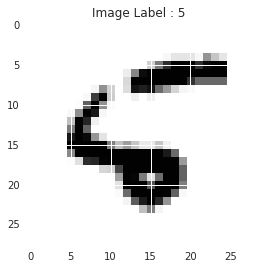

Predicted: 4


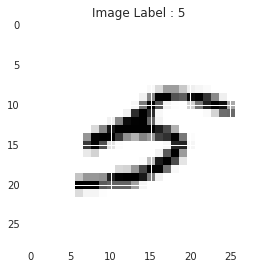

In [23]:
print "Predicted: 2"
show(rowconverter(mtest, 8))
print "Predicted: 4"
show(rowconverter(mtest, 167))

While our performance is significantly lower than the test errors reported by [Lecun, Cortes, and Burges](http://yann.lecun.com/exdb/mnist/) using basic classifiers, choosing this 'mean pixel' method provided a good opportunity to reinforce skills handling datasets in python, visualization tools, linear algebra, and model performance.  

## References
* [When Life is Linear, Tim Chartier](http://www.maa.org/press/ebooks/when-life-is-linear-from-computer-graphics-to-bracketology)
* https://www.kaggle.com/archaeocharlie/digit-recognizer/a-beginner-s-approach-to-classification
* https://gist.github.com/akesling/5358964
* http://colah.github.io/posts/2014-10-Visualizing-MNIST/
* http://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position
* https://en.wikipedia.org/wiki/Cosine_similarity
* https://en.wikipedia.org/wiki/Euclidean_distance
* http://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
* https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
* http://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
* https://matplotlib.org/users/colormaps.html
* https://stats.stackexchange.com/questions/21551/how-to-compute-precision-recall-for-multiclass-multilabel-classification
* https://stats.stackexchange.com/questions/160380/are-the-total-false-positives-and-false-negatives-of-a-large-confusion-matrix-eq
* http://yann.lecun.com/exdb/publis/pdf/lecun-95b.pdf